# Data Analytics 

## Prediction of fullblooded horses' value basing on parent matching

Authors: 

Michał Motyl
Kamil Pieprzycki

### Problem describtion
The aim of the project is to predict the potential value of racehorses obtained through parental crossbreeding. The main objective is to analyze the impact of sporting results and, based on that analysis, create models that will allow the estimation of investment value.

The reasearch can be a valuable information for investors and horsebreeders to predict investment profitability in horses trening and breeding. 

Data used for the purpose of this assignment comes from individual knowledge of the topic and following website:

- https://sporthorse-data.com/pedigree




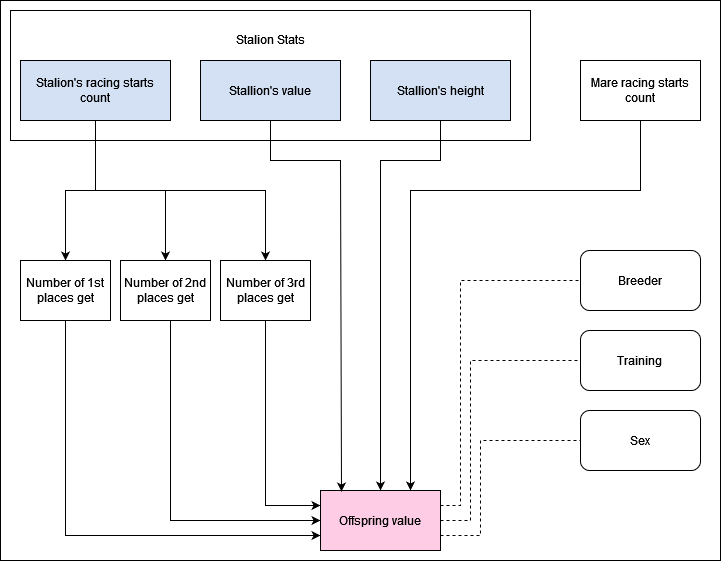

In [1]:
from PIL import Image
image = Image.open("offspring.png")
display(image)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from cmdstanpy import CmdStanModel
from cmdstanpy import install_cmdstan
 
#install_cmdstan()

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installing CmdStan version: 2.32.2
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpo1qbkcjh
Extracting distribution
Unpacked download as cmdstan-2.32.2
Building version cmdstan-2.32.2, may take several minutes, depending on your system.
Test model compilation
Installed cmdstan-2.32.2


True

## Data preparation

In [3]:
# imports
path_to_prep_mum = 'data/data_prepared/mums_prep.csv'
path_to_prep_dad = 'data/data_prepared/dads_prep.csv'
df_dads = pd.read_csv(path_to_prep_dad)
df_dads['dad_value_numeric_rescale'] = df_dads.dad_value_numeric /10**6


path_to_prepared_data = 'data/data_prepared/only_stalions_prepared.csv'
df = pd.read_csv(path_to_prepared_data)
df.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts
0,0,1,D1,S2,132570.0,8,156410.0,9.0,1.0,0.0,10.0
1,2,3,D1,S3,631605.0,11,1749869.0,43.0,8.0,5.0,66.0
2,3,4,D1,S4,8963.0,1,580806.0,14.0,2.0,2.0,18.0
3,4,5,D1,S4,4799.0,1,580806.0,14.0,2.0,2.0,18.0
4,7,58,D9,S5,209211.0,14,1176781.0,21.0,7.0,3.0,32.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40 non-null     int64  
 1   kid_id             40 non-null     int64  
 2   mum_id             40 non-null     object 
 3   dad_id             40 non-null     object 
 4   value_numeric      40 non-null     float64
 5   first_place        40 non-null     int64  
 6   dad_value_numeric  40 non-null     float64
 7   dad_first_place    40 non-null     float64
 8   dad_second_place   40 non-null     float64
 9   dad_third_place    40 non-null     float64
 10  dad_num_of_starts  40 non-null     float64
dtypes: float64(6), int64(3), object(2)
memory usage: 3.6+ KB


In [5]:
# rescaling values
df_copy = df.copy()
# for column in ['value_numeric', 'dad_value_numeric']:
#     new_col = column + '_rescale'
#     df_copy[new_col] = df[column]/10**6

columns_to_rescale = ['first_place', 'dad_first_place', 'dad_second_place', 'dad_third_place', 'value_numeric', 'dad_value_numeric', 'dad_num_of_starts']
df_copy[columns_to_rescale] -= df[columns_to_rescale].min()
df_copy[columns_to_rescale] /= df[columns_to_rescale].max()
df_copy.head()

,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts
0,0,1,D1,S2,0.097268,0.5000,0.089384,0.209302,0.111111,0.0,0.151515
1,2,3,D1,S3,0.469653,0.6875,1.000000,1.000000,0.888889,1.0,1.000000
2,3,4,D1,S4,0.005032,0.0625,0.331914,0.325581,0.222222,0.4,0.272727
3,4,5,D1,S4,0.001924,0.0625,0.331914,0.325581,0.222222,0.4,0.272727
4,7,58,D9,S5,0.154459,0.8750,0.672497,0.488372,0.777778,0.6,0.484848


## Histogram of data to be predicted

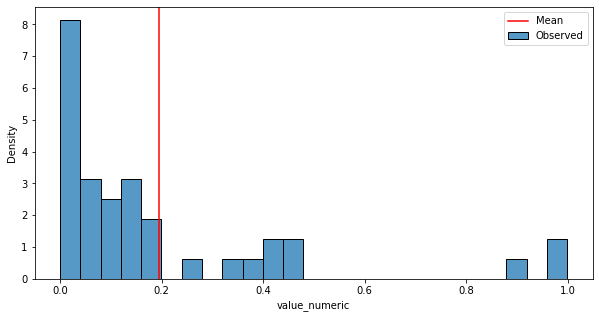

0.19465777732673586
0.2612924559240941


In [6]:
# analysis of value: what we want to to predict
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_copy, x='value_numeric', bins=25, ax=axs, label='Observed',stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()
print(df_copy.value_numeric.mean())
print(df_copy.value_numeric.std())

Calculting values for later basic ppc stan model

In [7]:
# mu_basic = log_maker(df_copy.value_numeric.mean(),df_copy.value_numeric.std())
# print(mu_basic)

## histograms of data we want to predict from


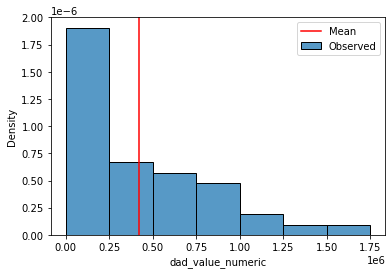

In [8]:
# histograms of data we want to predict from
graph = sns.histplot(data=df_dads, x='dad_value_numeric', label='Observed', stat='density')
graph.axvline(df_dads.dad_value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()

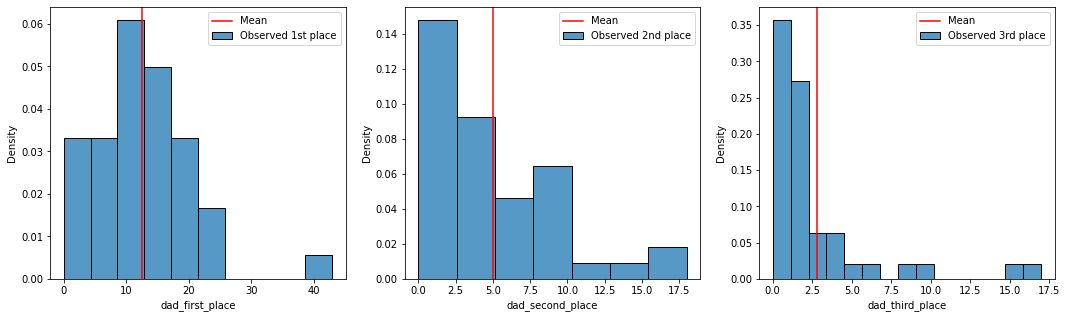

In [9]:
# places of dad
fig, axs = plt.subplots(1,3, figsize=(18,5))
graph = sns.histplot(data=df_dads, x='dad_first_place', label='Observed 1st place', ax=axs[0], stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_second_place', label='Observed 2nd place', ax=axs[1], stat='density')
graph.axvline(df_dads.dad_second_place.mean(), label='Mean', color='red')
graph.legend()

graph = sns.histplot(data=df_dads, x='dad_third_place', label='Observed 3rd place', ax=axs[2], stat='density')
graph.axvline(df_dads.dad_third_place.mean(), label='Mean', color='red')
graph.legend()
plt.show()

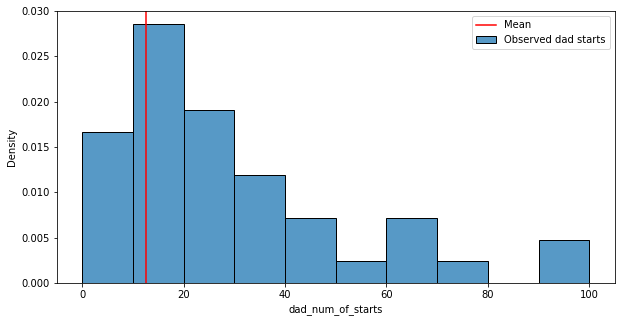

In [10]:
# nums of starts
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_dads, x='dad_num_of_starts', label='Observed dad starts', ax=axs, bins=10, stat='density')
graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')
graph.legend()
plt.show()


Assumed prior distributions:
- `dad_num_of_starts` : lognormal
- `dad_value_numeric_rescale` : exponential
- `dad_first_place` : lognormal
- `dad_second_place` : exponential
- `dad_third_place` : expnoential

In [11]:
def log_maker(mu,sigma):
    log_mu = np.log((mu**2)/np.sqrt(mu**2 + sigma**2))    
    log_sigma = np.sqrt(np.log(1+(sigma**2 )/(mu**2)))
    return log_mu,log_sigma

# calculating needed parameters for prior distributions
# to use in stan models in a bit

# rescaling df_dads before calculations
columns_to_rescale = ['dad_first_place', 'dad_second_place', 'dad_third_place', 'dad_value_numeric', 'dad_num_of_starts']
df_dads_copy = df_dads.copy()
df_dads_copy[columns_to_rescale] -= df_dads_copy[columns_to_rescale].min()
df_dads_copy[columns_to_rescale] /= df_dads_copy[columns_to_rescale].max()

# dad_num_of_starts
mu_dad_num_of_starts, sigma_dad_num_of_starts = log_maker(df_dads_copy.dad_num_of_starts.mean(),df_dads_copy.dad_num_of_starts.std())
# mu_dad_num_of_starts = df_dads.dad_num_of_starts.mean()
# sigma_dad_num_of_starts = df_dads.dad_num_of_starts.std()

# dad_value_numeric_rescale
lambda_dad_value_numeric_rescale = 1/df_dads_copy.dad_value_numeric_rescale.mean()

# dad_first_place
mu_dad_first_place, sigma_dad_first_place = log_maker(df_dads_copy.dad_first_place.mean(),df_dads_copy.dad_first_place.std())
# mu_dad_first_place = df_dads.dad_first_place.mean()
# sigma_dad_first_place = df_dads.dad_first_place.std()

# dad_second_place
lambda_dad_second_place = 1/df_dads_copy.dad_second_place.mean()

# dad_third_place
lambda_dad_third_place = 1/df_dads_copy.dad_third_place.mean()

data = {
        'mu_dad_num_of_starts': mu_dad_num_of_starts,
        'sigma_dad_num_of_starts': sigma_dad_num_of_starts,
        'mu_dad_first_place': mu_dad_first_place,
        "sigma_dad_first_place": sigma_dad_first_place,
        "lambda_dad_value_numeric_rescale": lambda_dad_value_numeric_rescale,
        "lambda_dad_second_place": lambda_dad_second_place,
        "lambda_dad_third_place": lambda_dad_third_place,        
}

print(data)


{'mu_dad_num_of_starts': -1.481740170128063, 'sigma_dad_num_of_starts': 0.7122777747804102, 'mu_dad_first_place': -1.4063011487708954, 'sigma_dad_first_place': 0.5909855553824085, 'lambda_dad_value_numeric_rescale': 2.370540413791375, 'lambda_dad_second_place': 3.5999999999999996, 'lambda_dad_third_place': 6.102564102564102}


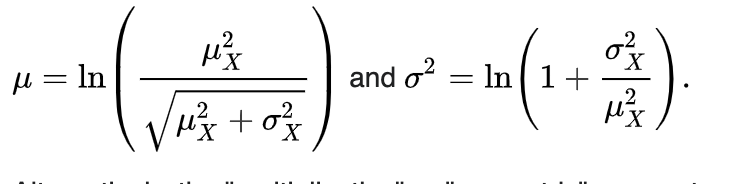

In [12]:
with open('models/distribution_check.stan') as file:
    print(file.read())
    file.close()

data {
    real mu_dad_num_of_starts;
    real sigma_dad_num_of_starts;
    real mu_dad_first_place;
    real sigma_dad_first_place;
    real lambda_dad_value_numeric_rescale;
    real lambda_dad_second_place;
    real lambda_dad_third_place;
}

generated quantities {
    real<lower=0> first_place = lognormal_rng(mu_dad_first_place, sigma_dad_first_place); 
    real<lower=0> num_of_start= lognormal_rng(mu_dad_num_of_starts, sigma_dad_num_of_starts);
    real<lower=0> value_numeric= exponential_rng(lambda_dad_value_numeric_rescale);
    real<lower=0> second_place = exponential_rng(lambda_dad_second_place);
    real<lower=0> third_place = exponential_rng(lambda_dad_third_place);
    
    real kid_value = exponential_rng(1/num_of_start);
}

// data {
//     real mu_dad_num_of_starts;
//     real sigma_dad_num_of_starts;
//     real mu_dad_first_place;
//     real sigma_dad_first_place;
//     real lambda_dad_value_numeric_rescale;
//     real lambda_dad_second_place;
//     real lambda_da

## Checking distribution model for data simulation

In [13]:
m_distribution_check=CmdStanModel(stan_file='models/distribution_check.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/distribution_check.stan to exe file /home/racehorse_bayes/models/distribution_check
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/distribution_check


In [14]:
data = {
        'mu_dad_num_of_starts': mu_dad_num_of_starts,
        'sigma_dad_num_of_starts': sigma_dad_num_of_starts,
        'mu_dad_first_place': mu_dad_first_place,
        
        "sigma_dad_first_place": sigma_dad_first_place,
        "lambda_dad_value_numeric_rescale": lambda_dad_value_numeric_rescale,
        "lambda_dad_second_place": lambda_dad_second_place,
        "lambda_dad_third_place": lambda_dad_third_place,
        
}


sim1_distribution_check=m_distribution_check.sample(data=data, seed=26062023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [15]:
ppc_distribution_chceck = sim1_distribution_check.draws_pd()
ppc_distribution_chceck.head()


,lp__,accept_stat__,first_place,num_of_start,value_numeric,second_place,third_place,kid_value
0,0.0,0.0,0.248393,0.114438,0.098246,0.365381,0.144113,0.065300
1,0.0,0.0,0.243103,0.077203,0.522891,0.433563,0.340484,0.075279
2,0.0,0.0,0.251015,0.058017,0.216147,0.646471,0.412611,0.010580
3,0.0,0.0,0.121003,0.186828,0.616947,0.201995,0.286595,0.113712
4,0.0,0.0,0.137864,0.685426,0.175233,0.055482,0.031021,1.649290


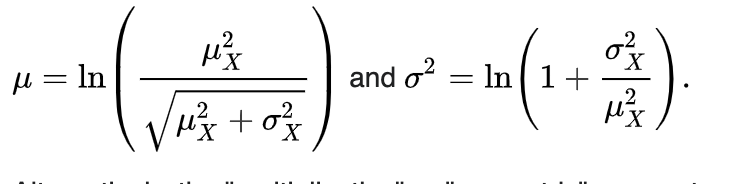

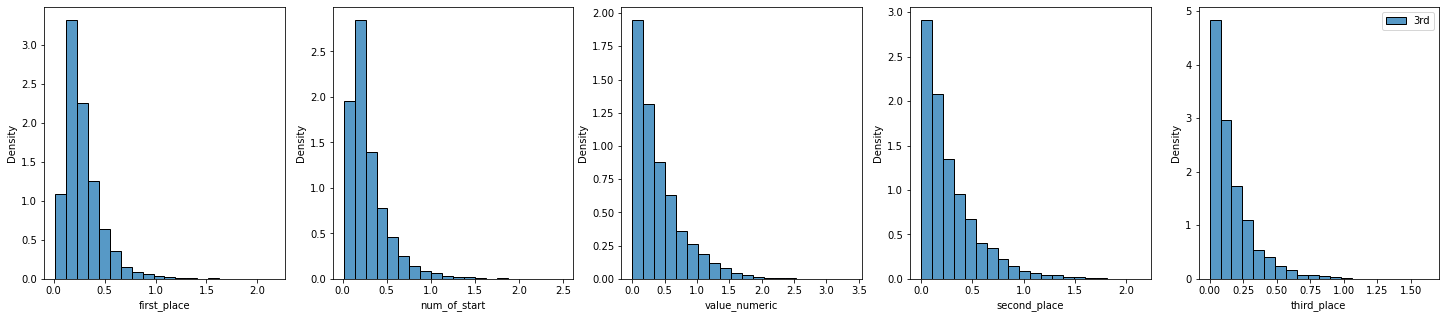

In [16]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['first_place']<100], x='first_place', label='Observed starts', ax=axs[0],bins=20,stat='density')

# graph.axvline(df_dads.dad_first_place.mean(), color='red', label='Mean')

graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['num_of_start']<100], x='num_of_start', label='Observed starts', ax=axs[1],bins=20,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['value_numeric']<100], x='value_numeric', label='value_numeric', ax=axs[2],bins=20,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['second_place']<100], x='second_place', label='2nd', ax=axs[3],bins=20,stat='density')
graph = sns.histplot(data=ppc_distribution_chceck[ppc_distribution_chceck['third_place']<100], x='third_place', label='3rd', ax=axs[4],bins=20,stat='density')

graph.legend()
plt.show()

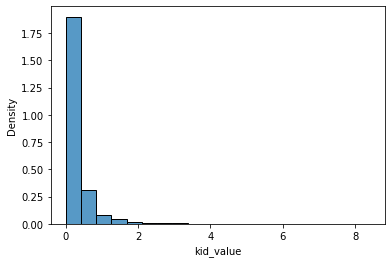

In [17]:

graph = sns.histplot(data=ppc_distribution_chceck, x='kid_value', label='Kid_value' ,bins=20 ,stat='density')

# Model 1 describtion 
1. The exponential distribution was chosen as the first model for predicting offspring values, as it was deemed the most suitable for our case.
2. The chosen distribution is suitable because the majority of horses being sold are priced lower, as it is an auction market and we do not assume any upper limits. Moreover, it should be noted that cases of expensive horses are very rare.

    The value of a horse is influenced by numerous variables, including some undefined ones such as individual training or rearing location. For the purposes of the project, assumptions were made to minimize their significance. The dataset consists of randomly selected horses that competed in races within a specified timeframe of 1968 to 1975 in the United States. With these assumptions, it can be inferred that rearing techniques and training methods were very similar. Additionally, the factor of jockeys in races with very similar physical conditions was omitted.
3. spośród wszystkich zmiennych poprzez eksplorację danych zawężono zbiór danych wejściowych do 5 zmiennych:
    - `dad_num_of_starts` - liczba sportowych startów ojców w wyścigach będąca wskaźnikiem zachowania wysokich warunków sportowych i niskiego zużywania się zwierząt
    - `dad_value_numeric_rescale` - wartość koni na koniec kariery sportowej
    - `dad_first_place` - liczba osiągniętych pierwszych miejsc w wyścigach
    - `dad_second_place` - liczba osiągniętych drugich miejsc w wyścigach
    - `dad_third_place` -  liczba osiągniętych trzecich miejsc w wyścigach

wzorki 
$$ output_{value} \sim Exponetial(\lambda) $$

$$ \lambda = predictor_i \cdot \beta + \alpha_0$$

Where: 

- $ \lambda $ cos tam - 
- $ \alpha_0 $ cos tam - 
- $ \beta $ - 



# Pior Predictive check - Model 1

The first step involved creating a simple generated quantities model without any predictors.
The mean value of offspring value - is sampled from a exponetial distibution The goal was to 
choose priors that would generate a sensible spread of offspring values.

In [18]:
model_basic=CmdStanModel(stan_file='models/model_basic.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/model_basic.stan to exe file /home/racehorse_bayes/models/model_basic
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/model_basic


In [19]:
R = 1000
sim_model_basic=model_basic.sample(iter_sampling=R,
                     iter_warmup=50,
                     chains=1,
                     fixed_param=True,
                     refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [20]:
basic_model_df = sim_model_basic.draws_pd()
basic_model_df.head()

,lp__,accept_stat__,value,num_of_starts,first_place,second_place,third_place,a0,a1,value_coeff,num_of_starts_coeff,first_place_coeff,second_place_coeff,third_place_coeff,mu,kid_value
0,0.0,0.0,2.373570,0.292767,0.187797,1.160020,0.145302,0.096436,0.084049,0.207274,0.391861,0.297355,0.292710,0.310349,0.529793,0.821285
1,0.0,0.0,0.247715,0.225494,0.250886,0.654124,0.082875,0.091794,0.047648,0.206718,0.389224,0.301805,0.295513,0.317754,0.239243,0.031819
2,0.0,0.0,0.450077,0.134341,0.379240,0.167800,0.225526,0.073737,0.140271,0.199797,0.390608,0.292170,0.302323,0.282103,0.150515,0.040280
3,0.0,0.0,0.531274,0.220612,0.201902,0.105568,0.062643,0.267658,0.031479,0.206987,0.406504,0.296167,0.308287,0.297346,0.273402,0.304302
4,0.0,0.0,1.099710,0.165723,0.369194,0.041153,0.368965,0.171306,0.051938,0.201066,0.394857,0.302955,0.302040,0.296798,0.319858,0.659520


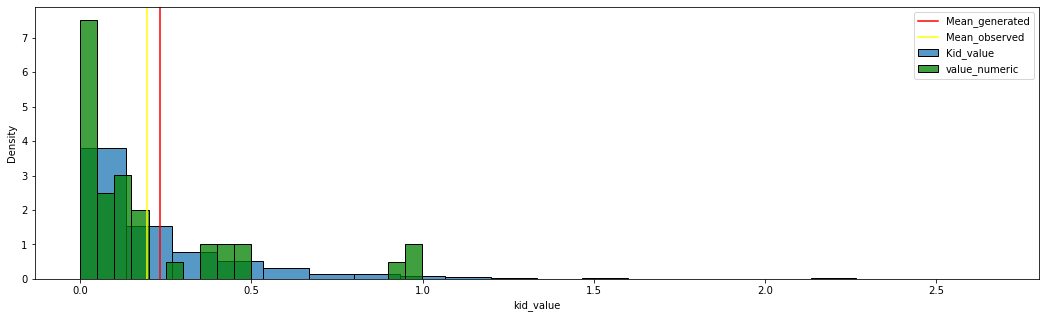

In [21]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(data=basic_model_df, x='kid_value',ax=axs,bins=20, label='Kid_value' ,stat='density')
graph.axvline(basic_model_df.kid_value.mean(), color='red', label='Mean_generated')
graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
graph.legend()


As can be observed the first basic model performs well with generating similar distribution for offspring value where the cheaper horses are much more often then the expensive ones. However it does not reflect it perfectly and it needs to be expanded.


# Posterior Check - MODEL 1 

The priors used in this model were the same as those in PPC model.


In [22]:
import arviz as az

In [23]:
fit_model_1=CmdStanModel(stan_file='models/model_ppc_ver2.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/model_ppc_ver2.stan to exe file /home/racehorse_bayes/models/model_ppc_ver2
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/model_ppc_ver2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/racehorse_bayes/models/model_ppc_ver2.hpp /home/racehorse_bayes/models/model_ppc_ver2.stan
Warning in '/home/racehorse_bayes/models/model_ppc_ver2.stan', line 25, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/racehorse_bayes/models/model_ppc_ver2.stan', line 67, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically u

In [24]:
data = { 'N': len(df_copy),
        'dad_value_numeric': df_copy['dad_value_numeric'].values,
        'dad_num_of_starts': df_copy.dad_num_of_starts,
        'dad_first_place': df_copy.dad_first_place,
        'dad_second_place': df_copy.dad_second_place,
        'dad_third_place': df_copy.dad_third_place,
        'kid_value': df_copy.value_numeric.values }

fit1=fit_model_1.sample(data=data, seed=69420)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [25]:
az.summary(fit1, var_names=['mu'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu[0],0.16,0.03,0.11,0.21
mu[1],0.48,0.03,0.43,0.53
mu[2],0.23,0.03,0.18,0.28
mu[3],0.23,0.03,0.18,0.28
mu[4],0.33,0.03,0.29,0.39
mu[5],0.31,0.03,0.26,0.35
mu[6],0.13,0.03,0.09,0.18
mu[7],0.13,0.03,0.09,0.18
mu[8],0.13,0.03,0.09,0.18
mu[9],0.13,0.03,0.09,0.18


In [26]:
predicted_df = fit1.draws_pd()
predicted_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a0,a1,value_coeff,...,log_likelihood[31],log_likelihood[32],log_likelihood[33],log_likelihood[34],log_likelihood[35],log_likelihood[36],log_likelihood[37],log_likelihood[38],log_likelihood[39],log_likelihood[40]
0,10.57940,0.992370,0.499184,3.0,7.0,0.0,-7.31875,0.399715,0.074425,0.212102,...,0.732767,1.11894,1.94787,0.872006,-2.93940,0.588783,1.64879,0.681142,1.35408,1.23028
1,10.79430,1.000000,0.499184,3.0,7.0,0.0,-9.49587,0.612129,0.083533,0.186869,...,0.667415,1.01179,1.65789,0.901232,-2.31538,0.538257,1.43786,0.625751,1.20203,1.09731
2,9.62536,0.988976,0.499184,3.0,7.0,0.0,-8.04074,0.653310,0.221403,0.206748,...,0.682678,1.03609,1.77778,0.905191,-2.50814,0.554795,1.51899,0.644458,1.25232,1.14167
3,7.63775,0.920969,0.499184,3.0,7.0,0.0,-5.04265,0.356421,0.023027,0.200492,...,0.755246,1.15797,1.95760,0.872945,-3.03268,0.598624,1.66681,0.692929,1.38046,1.25297
4,10.75550,0.942771,0.499184,3.0,7.0,0.0,-5.24533,0.514859,0.055696,0.191806,...,0.693513,1.05359,1.74641,0.906261,-2.52054,0.558103,1.50732,0.646268,1.25640,1.14525


In [27]:
predicted_df['mean_kid_value_pred'] =predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].mean(axis=1)
predicted_df['mean_mu'] = predicted_df.loc[:, "mu[1]":f"mu[{len(df_copy)}]"].mean(axis=1)

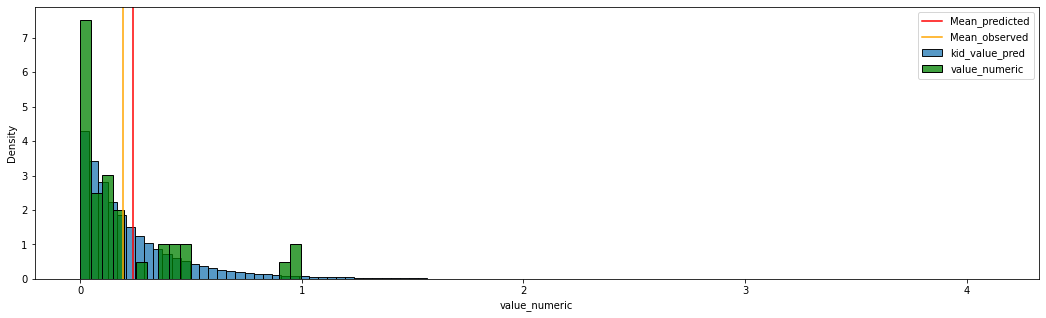

In [29]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
predicted = predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].values.reshape(-1)
graph = sns.histplot(data=predicted,ax=axs,bins=100, label='kid_value_pred',stat='density')
graph.axvline(predicted.mean(), color='red', label='Mean_predicted')
graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='orange', label='Mean_observed')
graph.legend()
# graph.set(xlim=(0,1))

Model with added posterior predictors performs well within range of the observed data. 
Used data contains peaks that is a result of action bidding. There is a long tail to the right side where values exceed the maximum observed horse values. There is no visible peaks for horses of higher values where interest of investors is reaching their barrier price.

poszukac modelu ktory schodzi jak exp ale wyplaszczaq sie wolniej

# Model 2 - Pior Predictive

suma podium / ilosc startow > 90%

In [51]:
firstpart=((df['dad_first_place']+df['dad_second_place']+df['dad_third_place'])>0.9*(df['dad_num_of_starts']))
secondpart=(df['dad_num_of_starts']>20)
df_copy['potential_to_be_expensive']=(firstpart & secondpart).astype(int)
df_copy.head()


,Unnamed: 0,kid_id,mum_id,dad_id,value_numeric,first_place,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,potential_to_be_expensive
0,0,1,D1,S2,0.097268,0.5000,0.089384,0.209302,0.111111,0.0,0.151515,0
1,2,3,D1,S3,0.469653,0.6875,1.000000,1.000000,0.888889,1.0,1.000000,0
2,3,4,D1,S4,0.005032,0.0625,0.331914,0.325581,0.222222,0.4,0.272727,0
3,4,5,D1,S4,0.001924,0.0625,0.331914,0.325581,0.222222,0.4,0.272727,0
4,7,58,D9,S5,0.154459,0.8750,0.672497,0.488372,0.777778,0.6,0.484848,1


In [62]:
model2_ppc=CmdStanModel(stan_file='models/model2_basic_v2.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/model2_basic_v2.stan to exe file /home/racehorse_bayes/models/model2_basic_v2
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/model2_basic_v2


In [63]:
R = 1000
sim_model2_ppc=model2_ppc.sample(iter_sampling=R,
                     iter_warmup=50,
                     chains=1,
                     fixed_param=True,
                     refresh=R)

model2_ppc_df = sim_model2_ppc.draws_pd()
model2_ppc_df.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,potential_rich,value,num_of_starts,first_place,second_place,third_place,a0,a1,value_coeff,num_of_starts_coeff,first_place_coeff,second_place_coeff,third_place_coeff,mu,sigma,mulog,sigmalog,kid_value
0,0.0,0.0,0.0,0.082765,0.439747,0.355519,0.095753,0.268336,0.381704,1.007220,0.202449,0.412553,0.307137,0.303236,0.305500,0.003000,0.073896,-9.01401,1.162610,0.000130
1,0.0,0.0,0.0,0.489747,0.313479,0.182072,0.181838,0.377557,0.253505,0.102552,0.208618,0.408738,0.293882,0.307287,0.304223,0.154375,0.098922,-2.04038,1.148600,0.225352
2,0.0,0.0,0.0,0.069314,1.613780,0.170481,0.195108,0.111320,0.192727,0.489811,0.213327,0.399707,0.304087,0.306191,0.299879,0.129927,0.101664,-2.27960,1.002300,0.119300
3,0.0,0.0,0.0,0.657339,0.120818,0.283579,0.022188,0.675835,0.063724,0.283697,0.194222,0.407663,0.292172,0.302157,0.300833,0.065455,0.112895,-3.41638,0.785355,0.013974
4,0.0,0.0,0.0,0.206299,0.123681,0.449967,1.626080,0.011428,0.049168,0.031865,0.196912,0.390275,0.303214,0.313625,0.316334,0.192057,0.093133,-1.75556,0.947968,0.650491


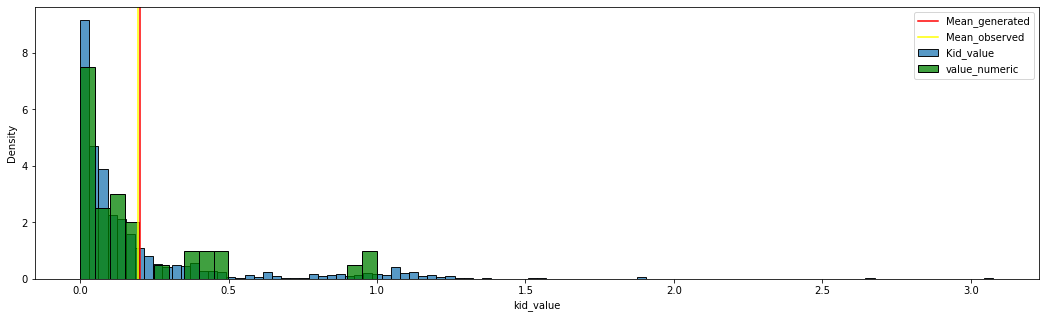

In [65]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
graph = sns.histplot(data=model2_ppc_df, x='kid_value',ax=axs,bins=100, label='Kid_value' ,stat='density')
graph.axvline(model2_ppc_df.kid_value.mean(), color='red', label='Mean_generated')
# graph = sns.histplot(data=model2_ppc_df, x='kid_value_rich',ax=axs,bins=100, label='Kid_value_rich' ,stat='density')
# graph.axvline(model2_ppc_df.kid_value_rich.mean(), color='red', label='Mean_generated_rich')
graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='yellow', label='Mean_observed')
graph.legend()


jupiiiiiii
:3

seks z pedałami 

In [34]:
log_maker(0.2,0.2)

(-1.956011502714073, 0.8325546111576977)

# Posterior Predictive check - Model 2

In [66]:
model2_fit=CmdStanModel(stan_file='models/model2_fit_ver2.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/model2_fit_ver2.stan to exe file /home/racehorse_bayes/models/model2_fit_ver2


INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/model2_fit_ver2


In [67]:
data = { 'N': len(df_copy),
        'dad_value_numeric': df_copy['dad_value_numeric'].values + 10**(-10),
        'dad_num_of_starts': df_copy.dad_num_of_starts + 10**(-10),
        'dad_first_place': df_copy.dad_first_place + 10**(-10),
        'dad_second_place': df_copy.dad_second_place + 10**(-10),
        'dad_third_place': df_copy.dad_third_place + 10**(-10),
        'kid_value': df_copy.value_numeric.values + 10**(-10),
        'potential_to_be_rich': df_copy.potential_to_be_expensive.values+ 10**(-10) }

fit2=model2_fit.sample(data=data, seed=69420)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


In [68]:
predicted_df = fit2.draws_pd()
predicted_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,a0,a1,...,log_likelihood[31],log_likelihood[32],log_likelihood[33],log_likelihood[34],log_likelihood[35],log_likelihood[36],log_likelihood[37],log_likelihood[38],log_likelihood[39],log_likelihood[40]
0,-5231.47,7.233510e-01,0.265763,2.0,3.0,0.0,5232.56,0.115335,0.371593,0.240387,...,0.929527,0.074579,0.418633,-0.037616,-2.88143,0.737784,0.653633,-162.444,1.033570,1.43610
1,-5231.47,6.461550e-52,0.265763,1.0,1.0,0.0,5240.80,0.115335,0.371593,0.240387,...,0.929527,0.074579,0.418633,-0.037616,-2.88143,0.737784,0.653633,-162.444,1.033570,1.43610
2,-5226.73,1.000000e+00,0.265763,3.0,7.0,0.0,5232.54,0.111746,0.313636,0.149372,...,0.907974,-0.024720,-0.055433,0.248591,-2.71873,0.731850,0.402420,-162.444,0.911439,1.36504
3,-5226.06,9.860190e-01,0.265763,3.0,15.0,0.0,5228.34,0.108433,0.238836,0.109018,...,0.926246,0.059058,0.323699,0.014739,-2.84925,0.736861,0.596316,-162.444,1.009590,1.42228
4,-5226.50,9.920960e-01,0.265763,4.0,15.0,0.0,5228.29,0.100916,0.184964,0.053241,...,0.918823,0.024505,0.177393,0.099694,-2.78873,0.734964,0.514376,-162.444,0.966567,1.39732


In [69]:
az.summary(fit2, var_names=['log_likelihood'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
log_likelihood[0],1.21,0.09,1.04,1.37
log_likelihood[1],-0.18,0.00,-0.19,-0.17
log_likelihood[2],-0.88,0.22,-1.26,-0.45
log_likelihood[3],-3.49,0.28,-3.98,-2.93
log_likelihood[4],-180.65,0.00,-180.65,-180.65
log_likelihood[5],-4444.68,0.00,-4444.68,-4444.68
log_likelihood[6],0.17,0.76,-1.27,1.54
log_likelihood[7],1.16,0.22,0.75,1.52
log_likelihood[8],-4.03,0.62,-5.22,-2.93
log_likelihood[9],0.68,0.27,0.18,1.15


[(0.0, 3.0)]

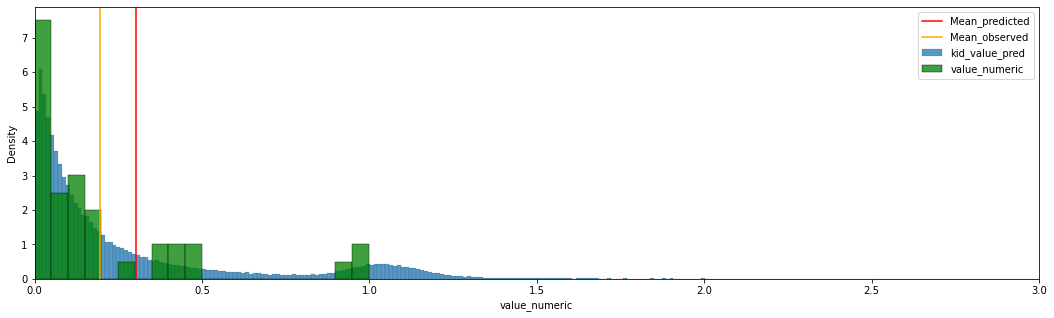

In [71]:
fig,axs= plt.subplots(1,1, figsize=(18,5))
predicted = predicted_df.loc[:, "kid_value_p[1]":f"kid_value_p[{len(df_copy)}]"].values.reshape(-1)
graph = sns.histplot(data=predicted,ax=axs,bins=1000, label='kid_value_pred',stat='density')
graph.axvline(predicted.mean(), color='red', label='Mean_predicted')
graph = sns.histplot(data=df_copy, x='value_numeric',ax=axs, color='green', label='value_numeric' ,bins=20 ,stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='orange', label='Mean_observed')
graph.legend()
graph.set(xlim=(0,3))

# TO DO POROWNANIE MODELI

In [72]:
fit1_id = az.from_cmdstanpy(posterior=fit1,
                            log_likelihood='log_likelihood',
                            posterior_predictive='kid_value_p',
                            observed_data={'kid_value': df_copy["value_numeric"]})

fit2_id = az.from_cmdstanpy(posterior=fit2,
                            log_likelihood='log_likelihood',
                            posterior_predictive='kid_value_p',
                            observed_data={'kid_value': df_copy["value_numeric"]})

tozklad lognromal ktry sie wpasuje

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


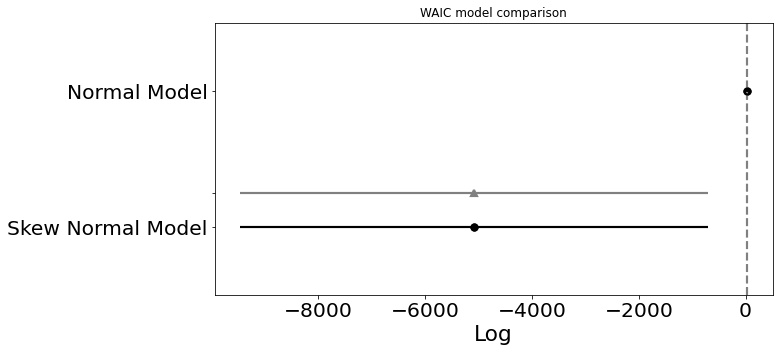

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Normal Model,0,21.617168,1.897745,0.00000,1.000000e+00,8.700010,0.000000,True,log
Skew Normal Model,1,-5086.749812,4.970319,5108.36698,4.433787e-12,4383.570907,4384.260031,True,log


In [73]:
waic = az.compare({'Normal Model': fit1_id, 'Skew Normal Model': fit2_id}, ic="waic")
az.plot_compare(waic, figsize=(10, 5))
plt.title("WAIC model comparison")
plt.show()
waic


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


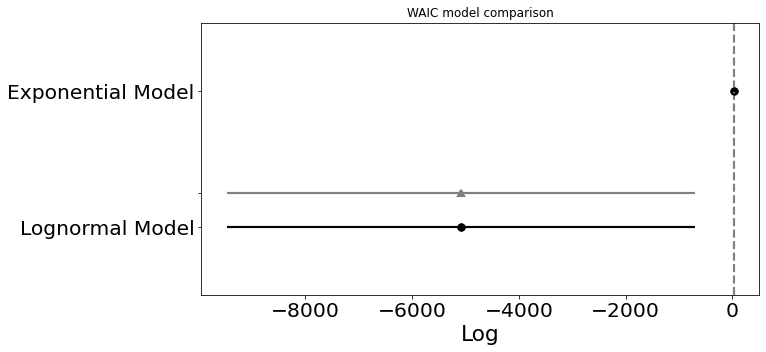

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Exponential Model,0,21.580019,1.934895,0.000000,1.000000e+00,8.710942,0.000000,False,log
Lognormal Model,1,-5086.851987,5.072495,5108.432006,4.369838e-13,4383.567644,4384.257743,True,log


In [75]:
waic = az.compare({'Exponential Model': fit1_id, 'Lognormal Model': fit2_id}, ic="loo")
az.plot_compare(waic, figsize=(10, 5))
plt.title("WAIC model comparison")
plt.show()
waic
